In [1]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

## Network


In [12]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

In [3]:
from pydantic import BaseModel, Field


class ResponseFormatter(BaseModel):
    next_agent: str = Field(
        description="The next agent to call. agent_1 or agent_2 or agent_3 or __end__",
    )
    content: str = Field(description="The content to send to the next agent.")

In [ ]:
model = ChatOpenAI(model="gpt-4o-mini").with_structured_output(ResponseFormatter)
model.invoke("hi!")

ResponseFormatter(next_agent='agent_1', content='Hello! How can I assist you today?')

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Bad request: invalid \'dotted_order\': dotted_order f1ebb21e-cbf6-4add-9838-f28440eca9d9 has timestamp 2025-04-16 11:13:11.268642 +0000 UTC earlier than parent timestamp 2025-04-16 11:13:12.927574 +0000 UTC for run_id:f1ebb21e-cbf6-4add-9838-f28440eca9d9 trace_id:93aa8a25-910f-489a-a6f1-e719ab164b9d dotted_order:20250416T111310871291Z93aa8a25-910f-489a-a6f1-e719ab164b9d.20250416T111312927138Z6a3b7a92-e1d8-4f25-8f15-6d1af04901f5.20250416T111312927574Zcd210166-31b6-43c7-826d-4fd96534b4e7.20250416T111311268642Zf1ebb21e-cbf6-4add-9838-f28440eca9d9 parent_run_id:cd210166-31b6-43c7-826d-4fd96534b4e7"}\n')


In [5]:
def agent_1(state: MessagesState) -> Command[Literal["agent_2", "agent_3", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    response = model.invoke(state["messages"])

    # route to one of the agents or exit based on the LLM's decision
    # if the LLM returns "__end__", the graph will finish execution
    return Command(
        goto=response.next_agent,
        update={"messages": [response.content]},
    )

In [6]:
def agent_2(state: MessagesState) -> Command[Literal["agent_1", "agent_3", END]]:
    response = model.invoke(state["messages"])

    return Command(
        goto=response.next_agent,
        update={"messages": [response.content]},
    )

In [7]:
def agent_3(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    response = model.invoke(state["messages"])

    return Command(
        goto=response.next_agent,
        update={"messages": [response.content]},
    )

In [8]:
builder = StateGraph(MessagesState)
builder.add_node(agent_1)
builder.add_node(agent_2)
builder.add_node(agent_3)

builder.add_edge(START, "agent_1")
network = builder.compile()

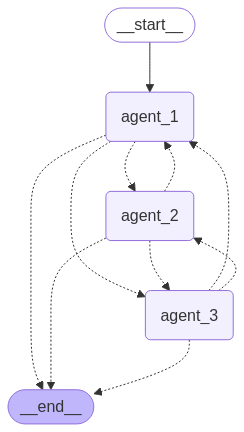

In [9]:
network

In [11]:
for chunk in network.stream(
    {
        "messages": [
            "以下の順番に、エージェントを呼び出してください。エージェント3、エージェント2、エージェント1。最後に終了します"
        ]
    },
    stream_mode="updates",
):
    print(chunk)

{'agent_1': {'messages': ['エージェント3を呼び出します。']}}
{'agent_3': {'messages': ['エージェント3を呼び出しました。']}}
{'agent_2': {'messages': ['エージェント3の応答を受けて、次はエージェント2を呼び出します。']}}
{'agent_2': {'messages': ['エージェント2を呼び出します。']}}
{'agent_2': {'messages': ['エージェント2の応答を受けて、次はエージェント1を呼び出します。']}}
{'agent_1': {'messages': ['エージェント1を呼び出します。']}}
{'agent_1': {'messages': ['エージェント1を呼び出しました。']}}


## Supervisor


In [13]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

In [ ]:
from pydantic import BaseModel, Field


class ResponseFormatter(BaseModel):
    next_agent: str = Field(
        description="The next agent to call. agent_1 or agent_2 or __end__",
    )
    content: str = Field(description="The content to send to the next agent.")


model = ChatOpenAI(model="gpt-4o-mini").with_structured_output(ResponseFormatter)

ResponseFormatter(next_agent='agent_1', content='Hello! How can I assist you today?')

In [31]:
def supervisor(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    response = model.invoke(state["messages"])

    # route to one of the agents or exit based on the supervisor's decision
    # if the supervisor returns "__end__", the graph will finish execution
    return Command(goto=response.next_agent)

In [32]:
def agent_1(state: MessagesState) -> Command[Literal["supervisor"]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # and add any additional logic (different models, custom prompts, structured output, etc.)
    response = "agent_1です。こんにちは！"
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

In [33]:
def agent_2(state: MessagesState) -> Command[Literal["supervisor"]]:
    response = "agent_2です。こんにちは！"
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

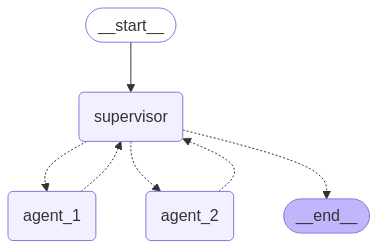

In [34]:
builder = StateGraph(MessagesState)
builder.add_node(supervisor)
builder.add_node(agent_1)
builder.add_node(agent_2)

builder.add_edge(START, "supervisor")

supervisor = builder.compile()
supervisor

In [38]:
for chunk in supervisor.stream(
    {
        "messages": [
            "エージェント2、エージェント1、エージェント2の順番に呼び出して終了してください"
        ]
    },
    stream_mode="updates",
):
    print(chunk)

{'supervisor': None}
{'agent_2': {'messages': ['agent_2です。こんにちは！']}}
{'supervisor': None}
{'agent_1': {'messages': ['agent_1です。こんにちは！']}}
{'supervisor': None}
{'agent_2': {'messages': ['agent_2です。こんにちは！']}}
{'supervisor': None}


## Supervisor (tool-calling)


In [39]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import InjectedState, create_react_agent

In [40]:
model = ChatOpenAI(model="gpt-4o-mini")

In [44]:
def agent_1(state: Annotated[dict, InjectedState]):
    "agent_1の処理を実行します"
    return {"messages": ["agent_1です。こんにちは！"]}


def agent_2(state: Annotated[dict, InjectedState]):
    "agent_2の処理を実行します"
    return {"messages": ["agent_2です。こんにちは！"]}

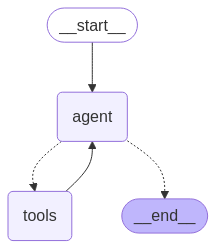

In [45]:
tools = [agent_1, agent_2]
supervisor = create_react_agent(model, tools)
supervisor

In [ ]:
for chunk in supervisor.stream(
    {"messages": ["エージェント2、エージェント1を順番に呼び出して終了してください"]},
    stream_mode="updates",
):
    print(chunk)
    print("-" * 100)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5PHv5pHzFZerfINSgMISLggL', 'function': {'arguments': '{}', 'name': 'agent_1'}, 'type': 'function'}, {'id': 'call_VvMOyMoZY2LCdRMuyEOh9De2', 'function': {'arguments': '{}', 'name': 'agent_2'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 88, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-06798746-6fc5-44ff-9600-6a5831692400-0', tool_calls=[{'name': 'agent_1', 'args': {}, 'id': 'call_5PHv5pHzFZerfINSgMISLggL', 'type': 'tool_call'}, {'name': 'agent_2', 'args': {}, 'id': 'call_VvMOyMoZY2LCdRMuyEOh9De2', 'type': 'tool